## KNN on titanic dataset

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score

Import the data and do some data processing

In [3]:
import openpyxl

# Red data
filename = 'DATA/titanic.xlsx'
df = pd.read_excel(filename, 1) #it has two sheets, we load the 2nd one
df.head()

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,1,1,29.0000,0,0,24160,211.3375,B5,2.0
1,1,1,0,0.9167,1,2,113781,151.5500,C22 C26,2.0
2,1,0,1,2.0000,1,2,113781,151.5500,C22 C26,2.0
3,1,0,0,30.0000,1,2,113781,151.5500,C22 C26,2.0
4,1,0,1,25.0000,1,2,113781,151.5500,C22 C26,2.0


We first need to remove useles variables and null values (or impute them) since KNN in scikit does not handle them

In [4]:
df.drop(labels=['cabin', 'ticket'], axis=1, inplace=True)
df.isnull().sum()

pclass        0
survived      0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64

In [5]:
df=df.dropna(subset=['embarked', 'age', 'fare'])
df.describe()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
count,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000
mean,2.209012,0.407478,0.370086,29.813199,0.504314,0.421860,36.603024,1.545542
std,0.840685,0.491601,0.483059,14.366261,0.913080,0.840655,55.753648,0.809366
min,1.000000,0.000000,0.000000,0.166700,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,8.050000,1.000000
50%,2.000000,0.000000,0.000000,28.000000,0.000000,0.000000,15.750000,2.000000
75%,3.000000,1.000000,1.000000,39.000000,1.000000,1.000000,35.077100,2.000000
max,3.000000,1.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000


Very important to **standardize** the data!

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

target = df["survived"] #we select the target variable before standardizing the data

columns = df.columns
standard_scaler = StandardScaler()
data = pd.DataFrame(standard_scaler.fit_transform(df), columns=df.columns)
data

#min_max_scaler = MinMaxScaler() - Another option
#data = min_max_scaler.fit_transform(data)

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,-1.438817,1.205868,1.304635,-0.056632,-0.552587,-0.502064,3.135549,0.561768
1,-1.438817,1.205868,-0.766498,-2.012379,0.543133,1.878176,2.062683,0.561768
2,-1.438817,-0.829278,1.304635,-1.936937,0.543133,1.878176,2.062683,0.561768
3,-1.438817,-0.829278,-0.766498,0.013009,0.543133,1.878176,2.062683,0.561768
4,-1.438817,-0.829278,1.304635,-0.335196,0.543133,1.878176,2.062683,0.561768
...,...,...,...,...,...,...,...,...
1038,0.941336,-0.829278,-0.766498,1.092443,-0.552587,-0.502064,-0.527178,-1.910486
1039,0.941336,-0.829278,1.304635,-1.066425,0.543133,-0.502064,-0.397453,-1.910486
1040,0.941336,-0.829278,-0.766498,-0.230734,-0.552587,-0.502064,-0.527178,-1.910486
1041,0.941336,-0.829278,-0.766498,-0.195914,-0.552587,-0.502064,-0.527178,-1.910486


And show pie chart with classes

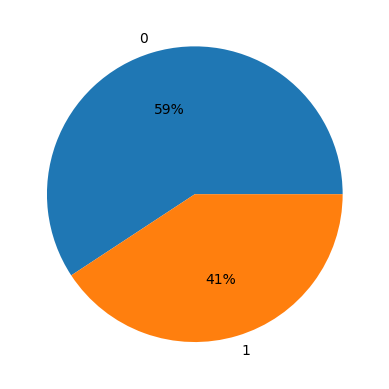

In [7]:
unique, counts = np.unique(target, return_counts=True)
plt.pie(counts, labels=unique, autopct='%.0f%%');

Now we create a function to do the data splitting, that we will use in a short while

In [8]:
from sklearn.model_selection import train_test_split 

# Train and test sets
def split_data(data, ratio):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=ratio, stratify=target)
    X_train.drop('survived', axis=1, inplace=True)
    X_test.drop('survived', axis=1, inplace=True)
    return X_train, X_test, y_train, y_test

### KNN model 1

First example with k=5

In [9]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(n_neighbors=5) # we don´t know yet the optimal number of neighbours

X_train, X_test, y_train, y_test = split_data(data, 0.2) 
print(X_train.shape)
print(X_test.shape)

(834, 7)
(209, 7)


In [10]:
knn_classifier.fit(X_train, y_train)

# Predictions (on test set, obviously)
knn_predictions = knn_classifier.predict(X_test)

# Calculate error_rate and print it
error_rate = 1 - accuracy_score(y_test, knn_predictions)
print("% Error (k=5): {0:.1%}".format(error_rate))

% Error (k=5): 24.4%


### Look for best option of  k (manually)

The idea now is to compare different splits and k values (hyper parameter), so we need a error measure calculation (1-accuracy), of course on the test set

In [11]:
def measure_error(num_iterations, K, ratio):
    perf = np.ones(num_iterations)
    for i in range(num_iterations):
        np.random.seed(i)
        X_train, X_test, y_train, y_test = split_data(data, ratio)
        knn_classifier = KNeighborsClassifier(n_neighbors=K)
        knn_classifier.fit(X_train, y_train)
        knn_predictions = knn_classifier.predict(X_test)
        error_rate = 1 - accuracy_score(y_test, knn_predictions)
        perf[i] = error_rate
    return np.mean(perf)

Now we produce several models, each with a different split between train and test set (from 50% train set to 90%), <BR>with different neighours values (from 5 to 15) and compare the errors of all them.
<BR>(we run it on 10 iterations to have it quicker, but normally from 50 is best)    

ratio (train set): 0.5
Neighbours: 5 , error: 0.213
Neighbours: 6 , error: 0.2075
Neighbours: 7 , error: 0.21
Neighbours: 8 , error: 0.2036
Neighbours: 9 , error: 0.2082
Neighbours: 10 , error: 0.205
Neighbours: 11 , error: 0.2063
Neighbours: 12 , error: 0.2061
Neighbours: 13 , error: 0.2073
Neighbours: 14 , error: 0.2103
Neighbours: 15 , error: 0.2123
ratio (train set): 0.6
Neighbours: 5 , error: 0.2214
Neighbours: 6 , error: 0.2126
Neighbours: 7 , error: 0.2155
Neighbours: 8 , error: 0.2072
Neighbours: 9 , error: 0.212
Neighbours: 10 , error: 0.2115
Neighbours: 11 , error: 0.2125
Neighbours: 12 , error: 0.2093
Neighbours: 13 , error: 0.2118
Neighbours: 14 , error: 0.2097
Neighbours: 15 , error: 0.2133
ratio (train set): 0.7
Neighbours: 5 , error: 0.2211
Neighbours: 6 , error: 0.2182
Neighbours: 7 , error: 0.2267
Neighbours: 8 , error: 0.2198
Neighbours: 9 , error: 0.2213
Neighbours: 10 , error: 0.2176
Neighbours: 11 , error: 0.2179
Neighbours: 12 , error: 0.2167
Neighbours: 13 , erro

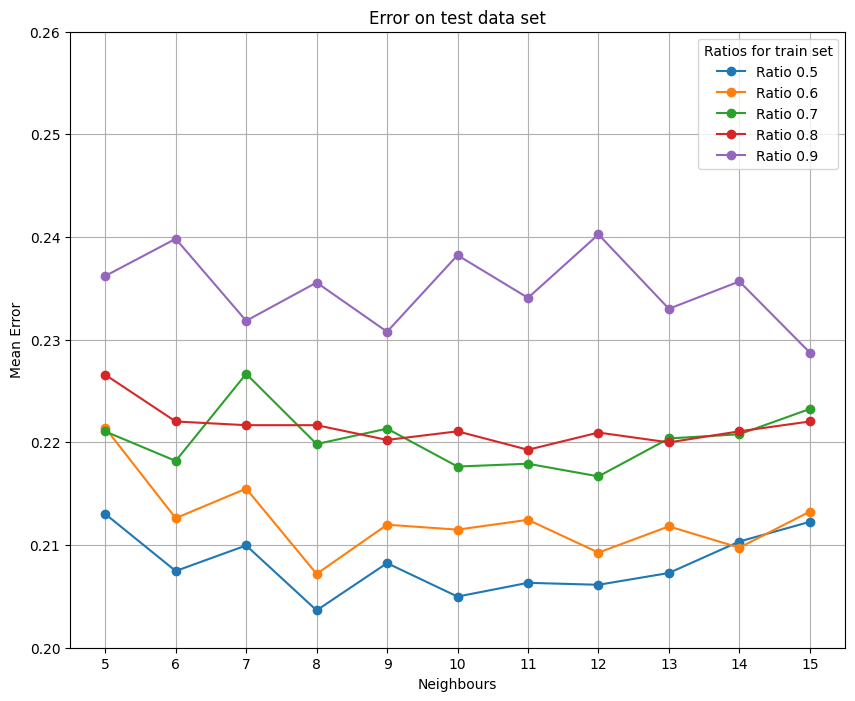

In [12]:
ratios = np.arange(0.5, 1.0, 0.1)
k_values = np.arange(5, 16)

plt.figure(figsize=(10, 8))
plt.xlabel("Neighbours")
plt.ylabel("Mean Error")

for ratio in ratios:
    print("ratio (train set):", np.round(ratio,2))
    mean_error=[]
    for K in k_values:
        error=measure_error(10, K, ratio) #10 iterations
        print("Neighbours:", K, ", error:", np.round(error,4))
        mean_error.append(error)
    
    plt.plot(k_values, mean_error, marker='o', label=f"Ratio {np.round(ratio,2)}")

plt.title("Error on test data set")
plt.legend(title="Ratios for train set")
plt.xticks(k_values)
plt.ylim(0.2, 0.26)
plt.grid(True)
plt.show()

And we can see that error starts to increase (with best ratio) from 8 neighbours approx. 
<BR>We can apply these values to our model and test

In [13]:
knn_classifier = KNeighborsClassifier(n_neighbors=8) 
X_train, X_test, y_train, y_test = split_data(data, 0.5) 
knn_classifier.fit(X_train, y_train)

knn_predictions = knn_classifier.predict(X_test)

error_rate = 1 - accuracy_score(y_test, knn_predictions)
print("% Error (k=8): {0:.1%}".format(error_rate))

% Error (k=8): 20.9%


### KNN model 2 (with grid search)

Second model, now we are looking for the best k parameter (from 1 to 50) and also the best weighting scheme from the two available <BR>(it is also possible to customize it in sklearn)

In [14]:
# Grid search
from sklearn.model_selection import GridSearchCV

parameters = {
    "n_neighbors": range(1, 51),
    "weights": ["uniform", "distance"] # try with both options
}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train, y_train) 

GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parameters)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 51),
                         'weights': ['uniform', 'distance']})

What are the best parameters found in the training dataset?

In [15]:
gridsearch.best_params_

{'n_neighbors': 17, 'weights': 'uniform'}

And obviously we now apply those values found, fit the model and make predictions

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_recall_curve, confusion_matrix, recall_score, precision_score

# Apply prediction 
train_preds_grid = gridsearch.predict(X_train)

gridpredictions = gridsearch.predict(X_test) #probability of being in both groups
error_rate = 1 - accuracy_score(y_test, gridpredictions)
print("% Error (grid search): {0:.1%}".format(error_rate))

% Error (grid search): 20.3%


We now create the ROC curve

Train Accuracy score:  82.92 %
Test Accuracy score:  79.69 %


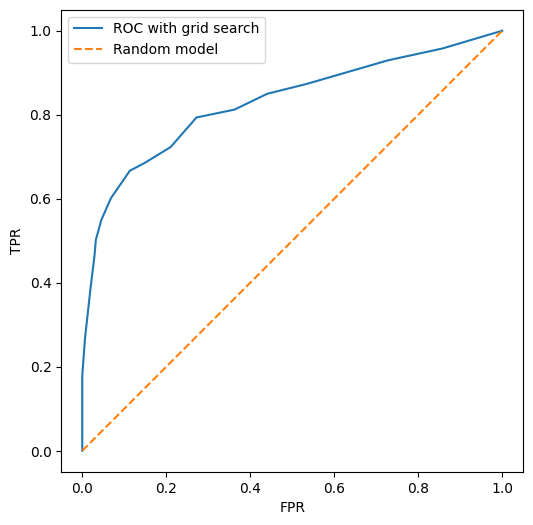

In [17]:
pred_prob = gridsearch.predict_proba(X_test) #probability of being in both groups
prob_1 = [p[1] for p in pred_prob] #probability of being in the survived group

auc = roc_auc_score(y_test, prob_1)

fpr, tpr, thresholds = roc_curve(y_test, prob_1, pos_label=1)

train_acc = round(gridsearch.score(X_train,y_train) * 100,2) #Train Accuracy score
test_acc = round(gridsearch.score(X_test,y_test) * 100,2) #Test Accuracy score
print("Train Accuracy score: ", train_acc, "%")
print("Test Accuracy score: ", test_acc, "%")

# ROC curve
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(fpr, tpr, label="ROC with grid search")
ax.plot([0, 1], [0, 1],linestyle='--', label="Random model") 
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_box_aspect(1)
ax.legend()
plt.show()

And confusion matrix

Confusion Matrix


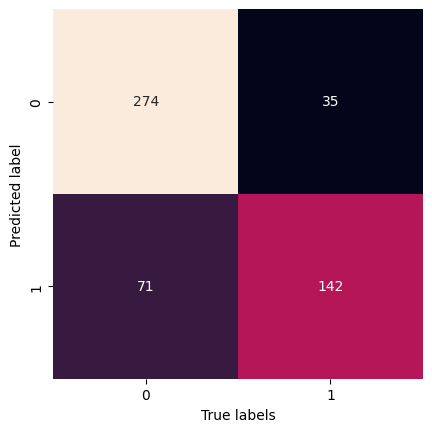

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Confusion Matrix")
conf_mat = confusion_matrix(y_test, gridpredictions)

# Draw heatmap using confusion matrix
sns.heatmap(conf_mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True labels')
plt.ylabel('Predicted label');

### KNN model 3 (bagging classifier)

In the last model we are implementing some bagging to KNN (using best parameters found with grid search)

In [20]:
best_k = gridsearch.best_params_["n_neighbors"]
best_weights = gridsearch.best_params_["weights"]

# this is the bagged model we will use
bagged_knn = KNeighborsClassifier( 
    n_neighbors=best_k, weights=best_weights
)

The method has many options, we are using here BaggingClassifier with 100 estimators

In [21]:
from sklearn.ensemble import BaggingClassifier

knnbagging_model = BaggingClassifier(bagged_knn, n_estimators=100) 
knnbagging_model.fit(X_train, y_train)

BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=17),
                  n_estimators=100)

And evaluate results with ROC curve and confusion matrix

Train Accuracy score:  82.92 %
Test Accuracy score:  79.69 %


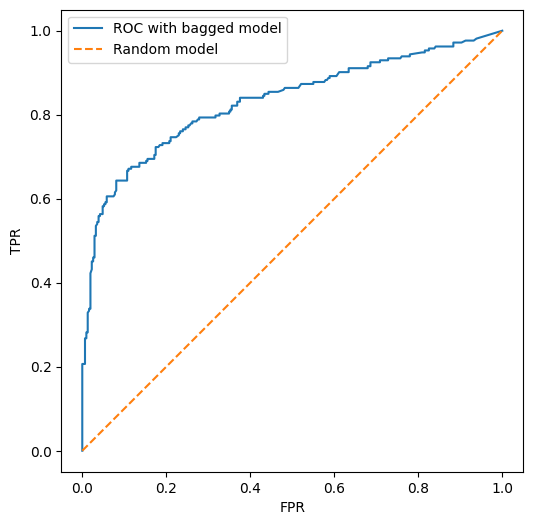

In [22]:
test_preds_grid = knnbagging_model.predict(X_test)

predictions = knnbagging_model.predict(X_test) 
pred_prob = knnbagging_model.predict_proba(X_test) #probability of being in both groups
prob_1 = [p[1] for p in pred_prob] #probability of being in the malign group
auc = roc_auc_score(y_test, prob_1)

fpr, tpr, thresholds = roc_curve(y_test, prob_1, pos_label=1)

train_acc = round(knnbagging_model.score(X_train,y_train) * 100,2) #Train Accuracy score
test_acc = round(knnbagging_model.score(X_test,y_test) * 100,2) #Test Accuracy score
print("Train Accuracy score: ", train_acc, "%")
print("Test Accuracy score: ", test_acc, "%")

# ROC curve
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(fpr, tpr, label="ROC with bagged model")
ax.plot([0, 1], [0, 1],linestyle='--', label="Random model") 
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_box_aspect(1)
ax.legend()
plt.show()

Confusion Matrix


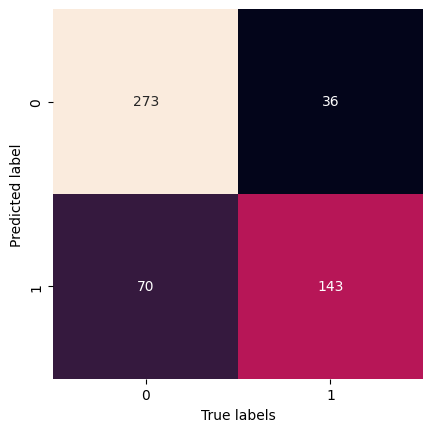

In [23]:
print("Confusion Matrix")
conf_mat = confusion_matrix(y_test, predictions)

# Draw heatmap using confusion matrix
sns.heatmap(conf_mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True labels')
plt.ylabel('Predicted label');

#### And finally, we can change the prediction threshold

In [24]:
threshold = 0.7  
customized_predictions = (knnbagging_model.predict_proba(X_test)[:,1] >= threshold).astype(int)

Can you anticipate whether we have more or less positives without executing the following code?

Confusion Matrix


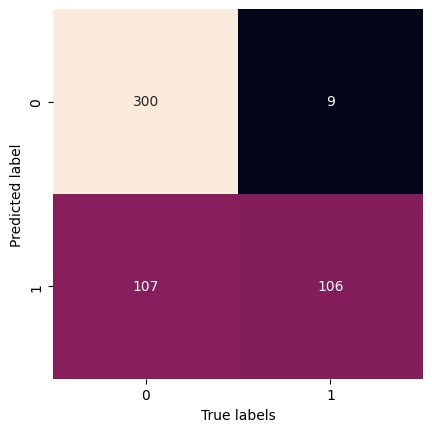

In [25]:
print("Confusion Matrix")
conf_mat = confusion_matrix(y_test, customized_predictions)

# Draw heatmap using confusion matrix
sns.heatmap(conf_mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True labels')
plt.ylabel('Predicted label');